In [1]:
import geopandas as gpd
import requests
import time
import shapely
import geopandas_osm.osm
import numpy as np
import descartes as d
import math
%matplotlib notebook

<IPython.core.display.Javascript object>


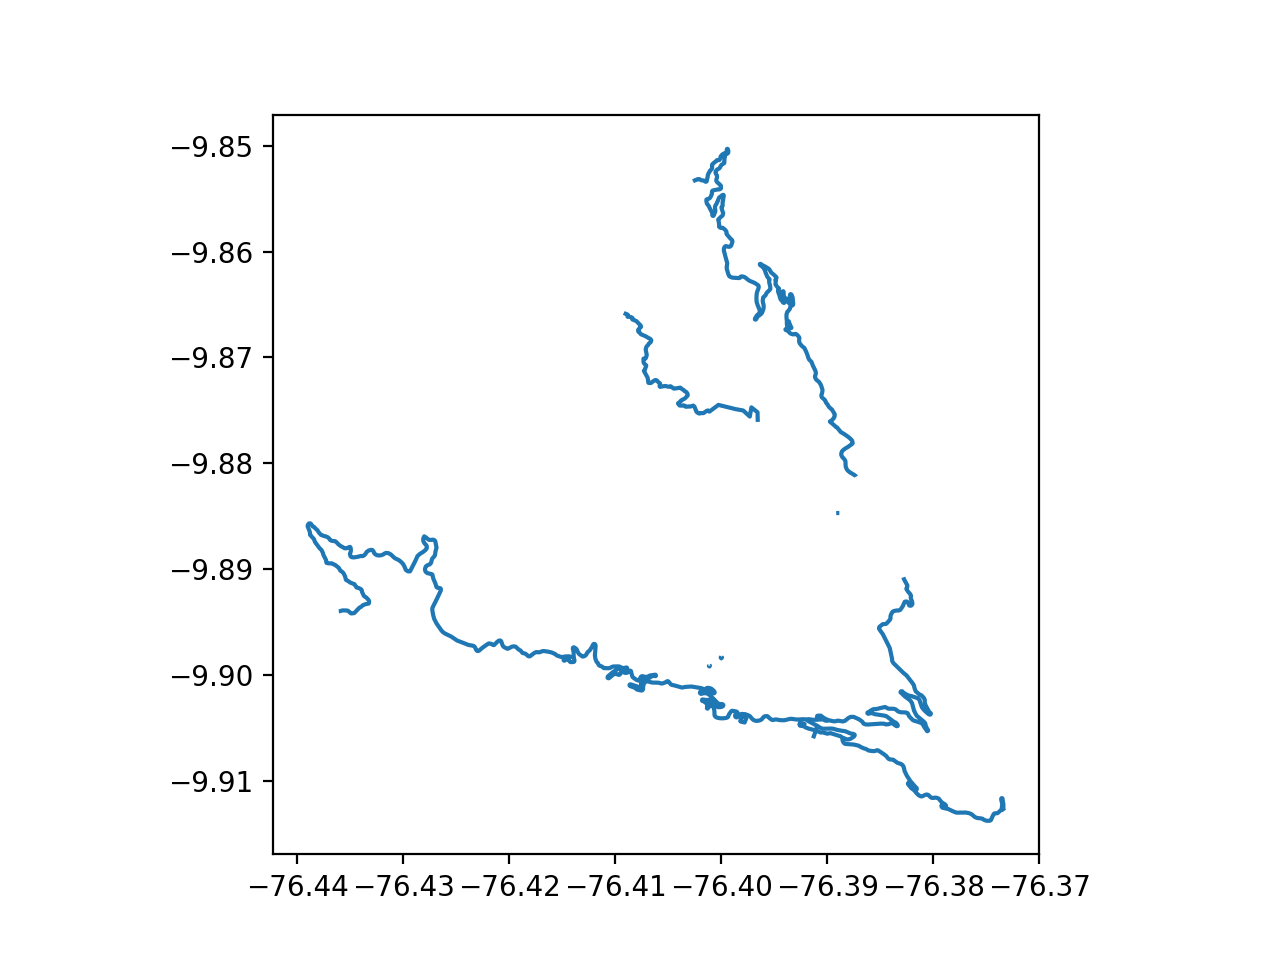

In [62]:
leftbound = -76.4092
rightbound = -76.3891
upperbound = -9.8721
lowerbound = -9.9083
bbox = [(leftbound,lowerbound ), (rightbound,lowerbound), (rightbound,upperbound), (leftbound,upperbound)]
poly = shapely.geometry.Polygon(bbox)
df = geopandas_osm.osm.query_osm('way', poly, recurse='down')
df.plot()

In [247]:
arr=["highway","residential", "primary", "secondary","tertiary","unclassified", "cycleway"]
df=df[df.highway.isin(arr)]
df["geometry"]


6    LINESTRING (-76.4493622 -9.872693999999999, -7...
7    LINESTRING (-76.4630418 -9.894894900000001, -7...
8    LINESTRING (-76.475937 -9.911633200000001, -76...
Name: geometry, dtype: object

In [108]:
newdata = gpd.GeoDataFrame()
newdata["street name"]=None
newdata["geometry"]=None
streetnewdata = gpd.GeoDataFrame()
streetnewdata["street name"]=None
streetnewdata["geometry"]=None
elev_point_data = gpd.GeoDataFrame()
elev_point_data["elevation"]=None
elev_point_data["geometry"]=None

In [4]:
elevations = dict()

In [5]:
print elevations

{}


In [6]:
all_coords_list = []
for geometry in df["geometry"]:
    for coord in geometry.coords:
        all_coords_list.append(coord)

In [124]:
def is_intersection(val):
    num_matches = 0
    for i in all_coords_list:
        if val == i:
            num_matches +=1
    
    if(num_matches > 1):
        return True
    else:
        return False
def is_bend(coord, a, b):
    a = get_vector(a, coord)
    b = get_vector(b, coord)
    anorm = math.sqrt(dot(a, a))
    bnorm = math.sqrt(dot(b, b))
    theta = math.acos(dot(a, b)/(anorm*bnorm))
    if(theta > 1.57):
        return False
    else:
        return True
def get_elev_diff(point1, point2):
        return get_elev(point1)-get_elev(point2)
def get_elev(point):
    if(point in elevations):
        return elevations[point]
    else:
        rqstring = "https://maps.googleapis.com/maps/api/elevation/json?locations="+str(point[0])+","+str(point[1])
        elevation=requests.get(rqstring)
        try:
            elev = elevation.json()["results"][0]["elevation"]
            elevations[point] = elev
            time.sleep(.1)
            return elev
        except:
            print elevation.json()
            time.sleep(.1)
            return 0
        
def distance(point1, point2):
    return math.hypot(point2[0]-point1[0], point2[1]-point1[1])
def dot(a, b):
    return float((a[0]*b[0])+(a[1]*b[1]))
def get_vector(point, origin):
    return (point[0]-origin[0], point[1]-origin[1])
def get_anchor_point(point1, point2, elev_diff):
    xv = get_vector(point1, point2)[0]
    yv = get_vector(point1, point2)[1]
    anchor = (-yv, xv)
    anchor = [i*elev_diff/distance(point1, point2) for i in anchor] 
    return (point1[0]+anchor[0], point1[1]+anchor[1])


def reproject_segment(seg, anchor, end, elev_diff):
    print "Beginning points: ",anchor, seg, end
    new_points = [anchor]
    for point in seg:
        a = get_vector(point, anchor)
        b = get_vector(end, anchor)
        project_point = point
        c = [dot(a, b)/dot(b,b)*i for i in b]
        p = (anchor[0]+c[0], anchor[1]+c[1])
        cur_point_elev_diff = elev_diff=round((get_elev(point)-max(elev1, elev2))*.001,7)
        p = get_anchor_point(p,end, cur_point_elev_diff)
        new_points.append(p)
    
    p_with_elev_diff = get_anchor_point(point2,point1, elev_diff)
    new_points.append(p_with_elev_diff)
    new_points.append(end)
    print "Projected points: ", new_points
    return new_points

In [125]:
new_index = -1
for index, geometry in zip(df.index.values, df["geometry"][0:1]):
    new_index +=1
    coords = geometry.coords
    coords_list = [i for i in coords]
    intersection_list = [0]
    index=1
    for coord in coords[1:-1]:
        if(is_intersection(coord)):
            intersection_list.append(index)
        #elif(is_bend(coord, coords[0], coords[-1])):
        #    intersection_list.append(index)
        index+=1
    intersection_list.append(int(len(coords)-1))

    print "Length of intersection list:", len(intersection_list)
    if(len(intersection_list) >= 2):
        if(len(intersection_list) == 2):
            point1 = coords_list[intersection_list[0]]
            point2 = coords_list[intersection_list[1]]
            elev1 = get_elev(point1)
            elev2 = get_elev(point2)
            elev_diff=round((elev1-elev2)*.001,7)
            seg_arr = reproject_segment(coords_list[1:-2], point1, point2, elev_diff)
        else:
            prev_index = 0    
            for i in intersection_list[1:-1]:
                #print "section from point ", coords[prev_index], "to point", coords[i], ":",
                point1 = coords_list[prev_index]
                point2 = coords_list[i]
                elev1 = get_elev(point1)
                elev2 = get_elev(point2)
                elev_diff=round((elev1-elev2)*.0001,7)
                seg_arr = reproject_segment(coords_list[prev_index+1:i-1], point1, point2, elev_diff)
                prev_index = i

    else:
        elev_diff=round(get_elev_diff(coords[0], coords[1])*.0001,7)
        seg_arr = coords_list  
        anchor = get_anchor_point(coords[0],coords[1], elev_diff)
        seg_arr.append(anchor)

    if(len(seg_arr) > 2):
        poly = shapely.geometry.Polygon(seg_arr)
        line = shapely.geometry.LineString(seg_arr[:-1]).buffer(0.000001)
        try:
            streetnewdata.loc[new_index, "geometry"] = line
            streetnewdata.loc[new_index, "street name"] = name
            newdata.loc[new_index, "geometry"] = poly
            newdata.loc[new_index, "street name"] = name
        except:
            continue

Length of intersection list: 2
Beginning points:  (-76.3732743, -9.9127882) [(-76.3733439, -9.9126978), (-76.3733661, -9.9126183), (-76.3733731, -9.9121263), (-76.3734204, -9.911907), (-76.3734412, -9.9116631), (-76.3734705, -9.9116028), (-76.3735233, -9.9115863), (-76.3735595, -9.9116096), (-76.3735776, -9.9116782), (-76.3735706, -9.9117768), (-76.3735108, -9.9119865), (-76.3734802, -9.9121756), (-76.3734955, -9.9123319), (-76.3735094, -9.9124155), (-76.3735219, -9.912595), (-76.373572, -9.9126868), (-76.3738892, -9.9129828), (-76.3739616, -9.913013), (-76.3740826, -9.9130212), (-76.3741842, -9.9130212), (-76.3742482, -9.9130527), (-76.374301, -9.9131295), (-76.3743748, -9.9132679), (-76.3745222, -9.9136187), (-76.3745765, -9.9136873), (-76.3746669, -9.9137201), (-76.3748366, -9.9137284), (-76.3749925, -9.9137147), (-76.3752137, -9.9136338), (-76.3753333, -9.9135351), (-76.3755281, -9.9134954), (-76.3758063, -9.9134693), (-76.3760234, -9.9133953), (-76.3761959, -9.9132597), (-76.37637

<IPython.core.display.Javascript object>


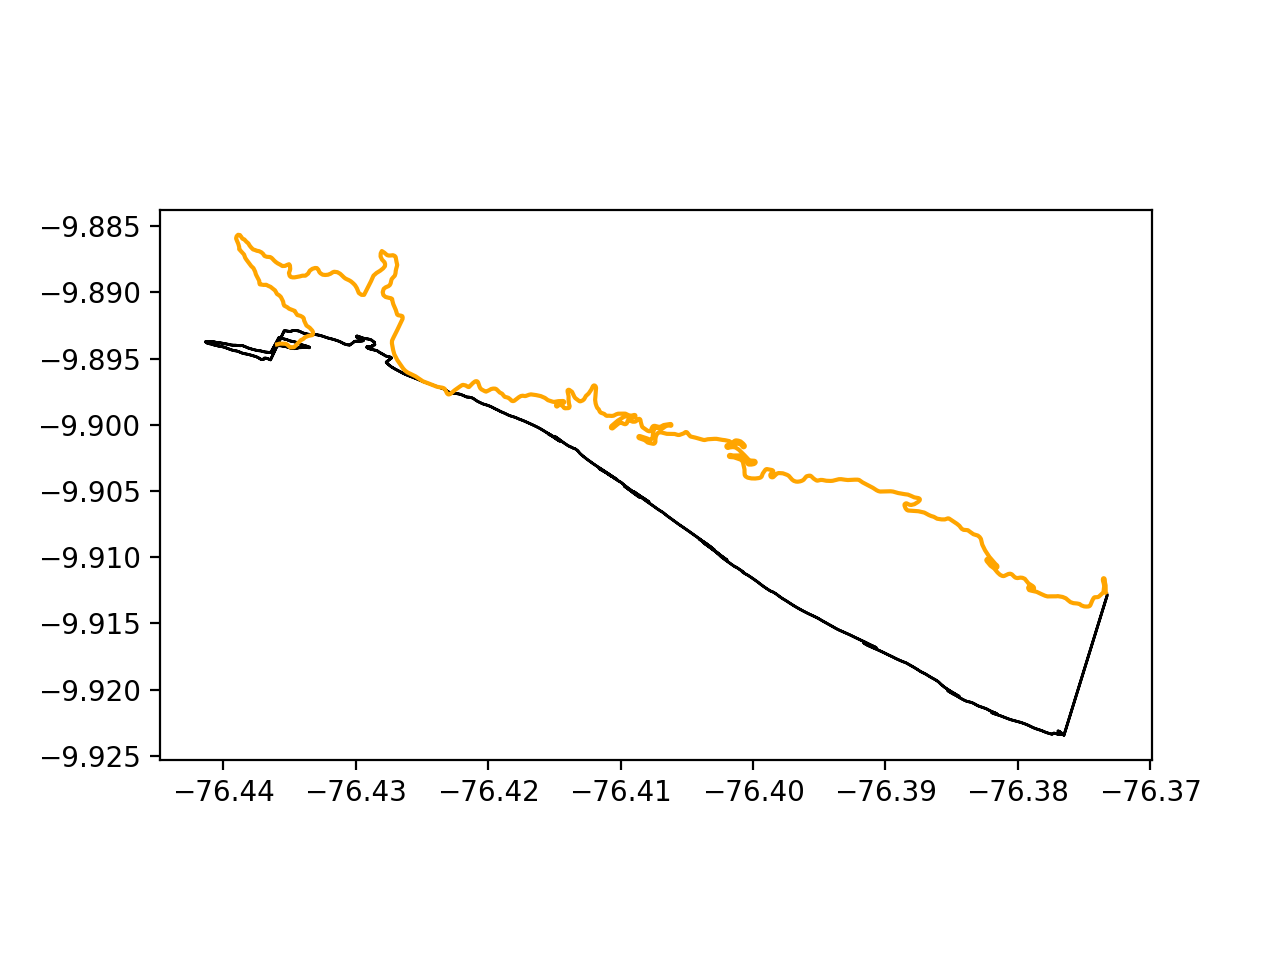

In [126]:
base = streetnewdata.plot(color='white', edgecolor='black')
newdata.plot(ax=base, color='green');
df.geometry[0:1].plot(ax=base, color="orange")

In [ ]:
elev_point_data

In [299]:
newdata.to_file("out_map.shp")
streetnewdata.to_file("out_street_map.shp")
elev_point_data.to_file("out_elev_map.shp")
